In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import scipy
import random

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [2]:
# Set some display options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

In [4]:
# Import src functions
sys.path.insert(0, src_folder)
from modeling import *
from stats_and_visualisations import *
from s3_storage import *

In [5]:
# Import data
X_train = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_X_train.npy')
X_test = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_X_test.npy')
y_train = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_y_train.npy')
y_test = from_s3(bucket='mimic-jamesi', filepath='data/acute_kidney_failure_y_test.npy')
print('--> Importing done')

--> Importing done


In [6]:
def train_lgb(X_train, y_train, n_folds, params, eval_metric, early_stopping_rounds):
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(X_train.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    print('LGB starting')
        
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(X_train):
        
        # Training data for the fold
        train_features  = X_train[train_indices]
        train_labels = [x for i,x in enumerate(y_train) if i in train_indices]
        # Validation data for the fold
        valid_features = X_train[valid_indices]
        valid_labels = [x for i,x in enumerate(y_train) if i in valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(**params)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = eval_metric,
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], early_stopping_rounds = early_stopping_rounds, verbose=0)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid'][eval_metric]
        train_score = model.best_score_['train'][eval_metric]
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
    
    # Overall validation score
    valid_auc = roc_auc_score(y_train, out_of_fold)

    # Overall training score
    train_auc = np.mean(train_scores)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(train_auc)
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})
        
    return metrics, train_auc, valid_auc

In [7]:
# define the grid search parameters
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(10, 150)),
    'learning_rate': list(np.linspace(0.001, 0.5)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_data_in_leaf': list(range(10, 250, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.001, 1)),
    'subsample': list(np.linspace(0.5, 1)),
    'is_unbalance': [True, False],
    'min_split_gain': list(np.linspace(0.001, 1)),
    'min_data_in_leaf': list(np.arange(1, 200, 3)),
    'n_estimators': list(np.arange(100, 20100, 1000))
}

In [8]:
def tune_lgb(X_train, y_train, param_grid, runs):
    
    ## -- Create output dataframe showing scores and associated hyperparameters
    df_cols = list(param_grid.keys())
    df_cols = df_cols + ['params', 'training_score', 'valid_score']

    runs_df = pd.DataFrame(columns=df_cols)
    total_runs = runs
    run =0

    while run < total_runs:

        run += 1

        # Select the random parameters
        random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}

        metrics, train_score, valid_score= train_lgb(X_train=X_train,
                                                      y_train=y_train,
                                                      n_folds = 5,
                                                      params = random_params,
                                                      eval_metric = 'auc',
                                                      early_stopping_rounds = 100)

        print("Run {},  Training score: {},  Valid score: {}".format(run, train_score, valid_score))
        
        temp_df = pd.DataFrame(columns=df_cols)

        for c in list(param_grid.keys()):
            temp_df.loc[0, c] = random_params[c]

        temp_df.loc[0, 'params'] = [random_params]
        temp_df.loc[0, 'training_score'] = train_score
        temp_df.loc[0, 'valid_score'] = valid_score

        runs_df = runs_df.append(temp_df)

        del temp_df, train_score, valid_score
        
    runs_df['training_score'] = runs_df['training_score'].astype(float)
    runs_df['valid_score'] = runs_df['valid_score'].astype(float)
    
    return runs_df

In [9]:
runs_df = tune_lgb(X_train, y_train, param_grid, runs=2).reset_index(drop=True)

LGB starting
Run 1,  Training score: 0.9824728628828149,  Valid score: 0.8827072479619273
LGB starting
Run 2,  Training score: 0.907140586743113,  Valid score: 0.8570776135249838


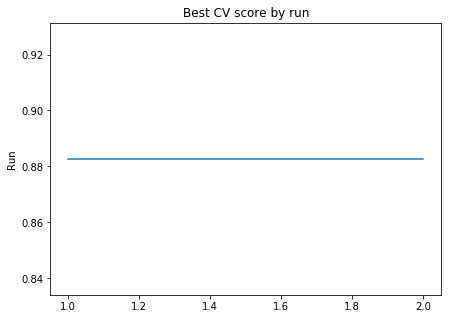

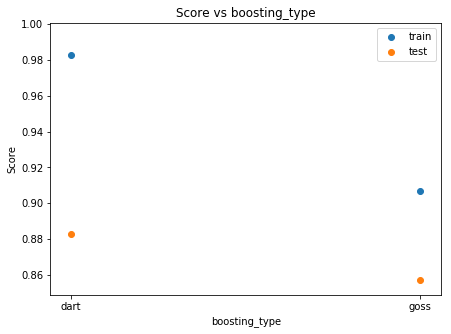

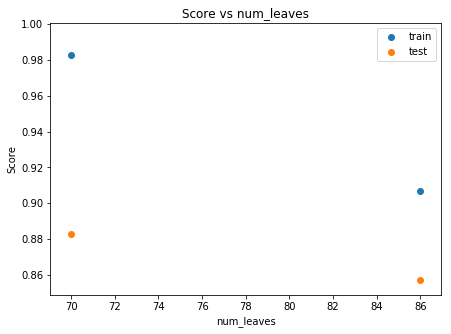

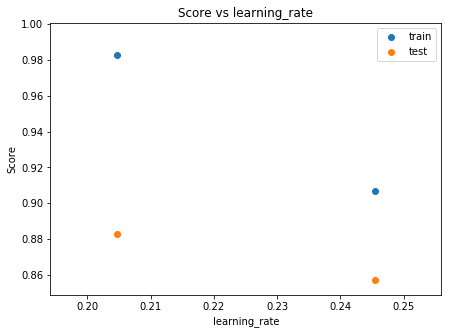

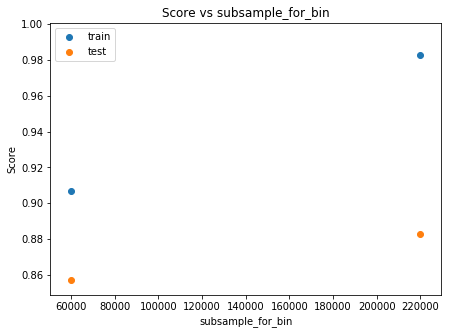

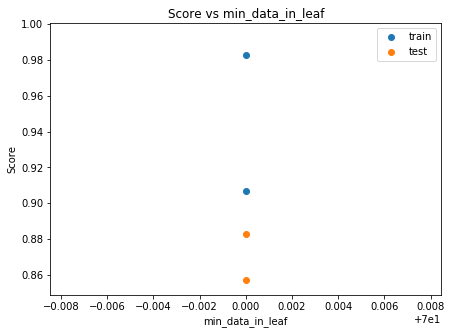

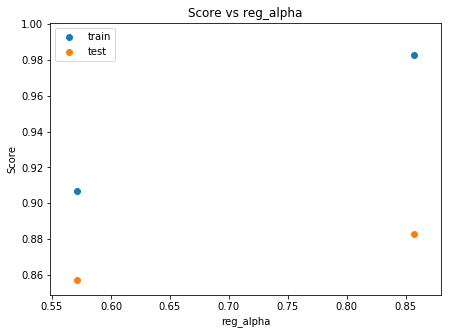

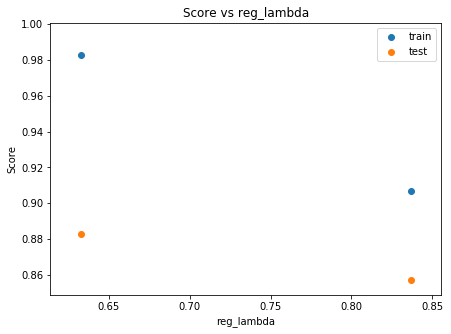

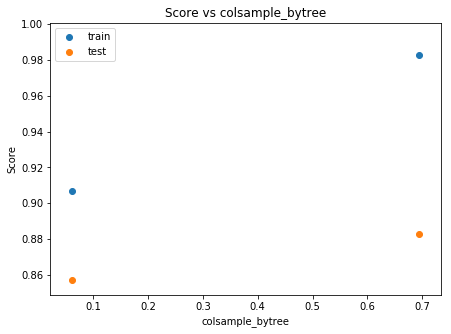

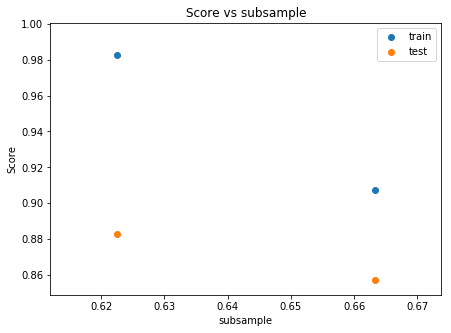

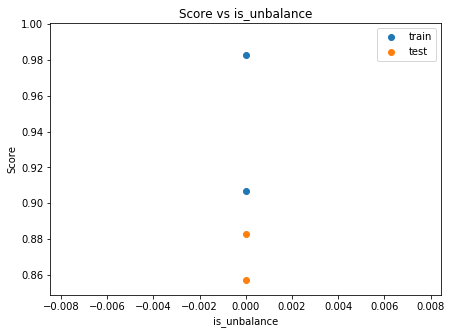

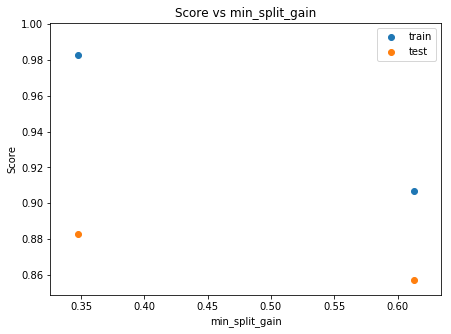

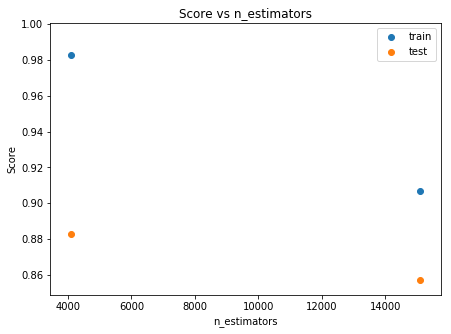

,boosting_type,num_leaves,learning_rate,subsample_for_bin,min_data_in_leaf,reg_alpha,reg_lambda,colsample_bytree,subsample,is_unbalance,min_split_gain,n_estimators,params,training_score,valid_score
0,dart,70,0.204673,220000,70,0.857143,0.632653,0.694184,0.622449,False,0.347592,4100,"[{'boosting_type': 'dart', 'num_leaves': 70, '...",0.982473,0.882707
1,goss,86,0.245408,60000,70,0.571429,0.836735,0.0621633,0.663265,False,0.612633,15100,"[{'boosting_type': 'goss', 'num_leaves': 86, '...",0.907141,0.857078


In [10]:
# Visualise best CV score by run
best_cv_by_run(runs_df, 'valid_score')

# Visualise the scores by single hyperparameters
plot_single_results(runs_df, 'training_score', 'valid_score', 'params')

# Find the best parameters
best_params=runs_df.loc[runs_df['valid_score'].max() == runs_df['valid_score'], 'params'][0][0]

runs_df.sort_values(by='valid_score', ascending=False)

In [11]:
# Re-run on best parameters and save model
final_run(X_train, y_train,
          best_params=best_params,
          classifier=lgb.LGBMClassifier,
          model_name='light_gbm')